In [114]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import cv2
import sqlite3
import pandas as pd

def is_float(s):
    try:
        float(s)
    except ValueError:
        return False
    else:
        return True
    
def offset2df(df,label,offset):
    l_multi=df_shot[label].values.tolist()
    l_multi_f = [float(s)-offset if is_float(s) else np.nan for s in l_multi]
    df[label+'_f']=l_multi_f
    return df

def inputXY(df):#inputXY(bounce_return,'1st','Nishioka') server_xとyとreturner_xとyの列を作成したい
    sx=[]
    sy=[]
    rx=[]
    ry=[]
    
    ballx_list=df['ballx_f'].values.tolist()
    bally_list=df['bally_f'].values.tolist()
    ballx_list = [float(s) if is_float(s) else np.nan for s in ballx_list]
    bally_list = [float(s) if is_float(s) else np.nan for s in bally_list]
    
    ballx_list = [float(s) for s in ballx_list]
    bally_list = [float(s) for s in bally_list]
    
    ax_list=df['playerAx_f'].values.tolist()
    ay_list=df['playerAy_f'].values.tolist()
    ax_list = [float(s) if is_float(s) else np.nan for s in ax_list]
    ay_list = [float(s) if is_float(s) else np.nan for s in ay_list]
    ax_list = [float(s) for s in ax_list]
    ay_list = [float(s) for s in ay_list]
    
    bx_list=df['playerBx_f'].values.tolist()
    by_list=df['playerBy_f'].values.tolist()
    bx_list = [float(s) if is_float(s) else np.nan for s in bx_list]
    by_list = [float(s) if is_float(s) else np.nan for s in by_list]
    bx_list = [float(s) for s in bx_list]
    by_list = [float(s) for s in by_list]
    
    for i in range(len(ay_list)):
        if(abs(ay_list[i]-bally_list[i])<abs(by_list[i]-bally_list[i])):#A⇒hit B⇒wait
            rx.append(bx_list[i])
            ry.append(by_list[i])
            sx.append(ax_list[i])
            sy.append(ay_list[i])
        else:            
            rx.append(ax_list[i])
            ry.append(ay_list[i])
            sx.append(bx_list[i])
            sy.append(by_list[i])
    return sx,sy,rx,ry#ヒットしている側⇒s 構えている側⇒r

dbname = './nishioka-nakajima_6-3_6-7_4-6.db'
conn = sqlite3.connect(dbname)
c = conn.cursor()
#df_score = pd.read_sql("select * from score", conn)
df_score=pd.read_csv("./fix_score.csv")
df_match = pd.read_sql("select * from match", conn)
df_shot = pd.read_sql("select * from shot", conn)

# df_score_1set=df_score[df_score['Set']=='0-0']
# df_score_2set=df_score[df_score['Set']=='1-0']
# df_score_3set=df_score[df_score['Set']=='1-1']

#df_shotに'game' 'server'を追加する(df_gameを参照)
server_returner=df_score['Server'].dropna().unique()

server_list=[]
returner_list=[]
game_list=[]
count=0
hitplayer_list=[]
pre_point=0
nth_list=[]
winner_list=[]
for i in range(len(df_shot['point'])):
    point=df_shot['point'][i]
    server=df_score[df_score['index']==point]['Server'].values[0]#unique()
    server_list.append(server)
    returner=set(server_returner) - set([server])
    game_list.append(df_score[df_score['index']==point]['Game'].values[0])
    returner_list.append(list(returner)[0])
    winner=df_score[df_score['index']==point]['PointWinner'].values.tolist()[0]
    winner_list.append(winner)
    if(point>pre_point):
        count=0
    if(count%4<2):
        hitplayer_list.append(list(returner)[0])
    else:
        hitplayer_list.append(server)
    nth_list.append(count)
    count+=1
    pre_point=point
        
    
df_shot['Server']=server_list
df_shot['Returner']=returner_list
df_shot['Game']=game_list
df_shot['hitplayer']=hitplayer_list
df_shot['winner']=winner_list

#座標の基準を変える
x_offset=10.97/2
y_offset=23.78/2
df_shot=offset2df(df_shot,'ballx',x_offset)
df_shot=offset2df(df_shot,'bally',y_offset)
df_shot=offset2df(df_shot,'playerAx',x_offset)
df_shot=offset2df(df_shot,'playerAy',y_offset)
df_shot=offset2df(df_shot,'playerBx',x_offset)
df_shot=offset2df(df_shot,'playerBy',y_offset)

sx,sy,rx,ry=inputXY(df_shot)
df_shot['hitplayer_x']=sx
df_shot['hitplayer_y']=sy
df_shot['waitplayer_x']=rx
df_shot['waitplayer_y']=ry
df_shot['nth']=nth_list

In [41]:
i=1
point=df_shot['point'][i]
df_score[df_score['index']==point]['PointWinner'].values.tolist()[0]

'Nakashima'

In [46]:
df_shot

,index,point,frame,ballx,bally,playerAx,playerAy,playerBx,playerBy,hitplayer,bouncehit,foreback,direction,Server,Returner,Game
0,0,1,861.0,12.2,23.47,4.57,-1.97,10.0,23.47,Nishioka,Hit,Fore,Cross,Nakashima,Nishioka,0-0
1,1,2,1296.0,5.42,17.15,,,,,Nishioka,Bounce,,Cross,Nakashima,Nishioka,0-0
2,2,3,1730.0,9.26,16.21,,,,,Nishioka,Bounce,,Cross,Nakashima,Nishioka,0-0
3,3,3,1742.0,13.96,24.5,4.57,-0.04,11.12,24.5,Nishioka,Hit,Fore,Cross,Nakashima,Nishioka,0-0
4,4,4,2241.0,2.23,16.56,,,,,Nishioka,Bounce,,Cross,Nakashima,Nishioka,0-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,1986,304,261291.0,3.98,-1.62,4.65,-1.62,5.72,26.08,Nakashima,Hit,Fore,Cross,Nishioka,Nakashima,4-5
1987,1987,304,261320.0,8.7,23.42,,,,,Nishioka,Bounce,,Cross,Nishioka,Nakashima,4-5
1988,1988,304,261327.0,9.6,26.74,5.42,-1.85,8.37,26.74,Nishioka,Hit,Fore,Cross,Nishioka,Nakashima,4-5
1989,1989,304,261353.0,4.01,5.74,,,,,Nakashima,Bounce,,Cross,Nishioka,Nakashima,4-5


In [126]:
df_shot.to_csv("test.csv")

In [6]:
df_shot[df_shot['hitplayer']=='Nishioka']

,index,point,frame,ballx,bally,playerAx,playerAy,playerBx,playerBy,hitplayer,...,ballx_f,bally_f,playerAx_f,playerAy_f,playerBx_f,playerBy_f,server_x,server_y,returner_x,returner_y
0,0,1,861.0,12.2,23.47,4.57,-1.97,10.0,23.47,Nishioka,...,6.715,11.58,-0.915,-13.86,4.515,11.58,-0.915,-13.86,4.515,11.58
1,1,2,1296.0,5.42,17.15,,,,,Nishioka,...,-0.065,5.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3,1730.0,9.26,16.21,,,,,Nishioka,...,3.775,4.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,1742.0,13.96,24.5,4.57,-0.04,11.12,24.5,Nishioka,...,8.475,12.61,-0.915,-11.93,5.635,12.61,-0.915,-11.93,5.635,12.61
4,4,4,2241.0,2.23,16.56,,,,,Nishioka,...,-3.255,4.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,1980,304,261170.0,7.33,24.9,3.42,-3.18,6.4,24.9,Nishioka,...,1.845,13.01,-2.065,-15.07,0.915,13.01,-2.065,-15.07,0.915,13.01
1983,1983,304,261241.0,7.41,22.93,,,,,Nishioka,...,1.925,11.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,1984,304,261249.0,7.72,25.84,4.64,-2.25,6.62,25.84,Nishioka,...,2.235,13.95,-0.845,-14.14,1.135,13.95,-0.845,-14.14,1.135,13.95
1987,1987,304,261320.0,8.7,23.42,,,,,Nishioka,...,3.215,11.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
def drawCourt(ax):#テニスコートラインを描画
    x_offset=10.97/2
    y_offset=23.78/2
    #横線
    ax.plot([0-x_offset,10.97-x_offset], [11.89-y_offset,11.89-y_offset], color = "green")
    ax.plot([0-x_offset,10.97-x_offset], [0-y_offset,0-y_offset], color = "green")
    ax.plot([0-x_offset,10.97-x_offset], [11.89*2-y_offset,11.89*2-y_offset], color = "green")
    ax.plot([10.97/2-x_offset,10.97/2-x_offset], [5.49-y_offset,11.89*2-5.49-y_offset], color = "green")

    #縦線
    ax.plot([0-x_offset,0-x_offset], [0-y_offset,11.89*2-y_offset], color = "green")
    ax.plot([1.37-x_offset,1.37-x_offset], [0-y_offset,11.89*2-y_offset], color = "green")
    ax.plot([1.37+8.23-x_offset,1.37+8.23-x_offset], [0-y_offset,11.89*2-y_offset], color = "green")
    ax.plot([1.37+8.23+1.37-x_offset,1.37+8.23+1.37-x_offset], [0-y_offset,11.89*2-y_offset], color = "green")

    ax.plot([1.37-x_offset,1.37+8.23-x_offset], [5.49-y_offset,5.49-y_offset], color = "green")
    ax.plot([1.37-x_offset,1.37+8.23-x_offset], [11.89*2-5.49-y_offset,11.89*2-5.49-y_offset], color = "green")
    
    return ax

def plot_bounce(x,y):
    fig=plt.figure(figsize=(10.0, 10.0))
    ax1 = fig.add_subplot(1,2,1)
    # ax2 = fig.add_subplot(1,2,2)
    ax1=drawCourt(ax1)
    ax1.set_aspect('equal')
    ax1.scatter(x,y,s=5,label='1st')
    ax1.set_xlim(-10,10)
    ax1.set_ylim(-18,18)
    
def reverseXYList(xlist,ylist,plusminus):
    xlist_r=[]
    ylist_r=[]
    for i, (x, y) in enumerate(zip(xlist, ylist)):
        if(plusminus=="plus"):
            if(y<0):
                y=-y
                x=-x
        elif(plusminus=="minus"):
            if(y>0):
                y=-y
                x=-x
        xlist_r.append(x)
        ylist_r.append(y)
    ave = sum(ylist_r)/len(ylist_r)
    #print(ave)
    return xlist_r,ylist_r,ave

    
#ballx=df_shot['ballx_f'].values.tolist()
#bally=df_shot['bally_f'].values.tolist()

#リターン返球後のデータだけを抽出
df_shot_nakashima=df_shot[(df_shot['hitplayer']=='Nakashima')&(df_shot['bouncehit']=='Hit')&(df_shot['nth']>1)]

ballx=df_shot_nakashima['ballx_f'].values.tolist()
bally=df_shot_nakashima['bally_f'].values.tolist()


ballx,bally,ave=reverseXYList(ballx,bally,"plus")

# player_a_x=df_shot_nakashima['playerAx_f'].values.tolist()
# player_a_y=df_shot_nakashima['playerAy_f'].values.tolist()

player_wait_x_list=df_shot_nakashima[df_shot_nakashima['Server']=='Nakashima']['waitplayer_x'].values.tolist()
player_wait_y_list=df_shot_nakashima[df_shot_nakashima['Server']=='Nakashima']['waitplayer_y'].values.tolist()

ball_x_list=df_shot_nakashima[df_shot_nakashima['Server']=='Nakashima']['ballx_f'].values.tolist()
ball_y_list=df_shot_nakashima[df_shot_nakashima['Server']=='Nakashima']['bally_f'].values.tolist()
winner_list=df_shot_nakashima[df_shot_nakashima['Server']=='Nakashima']['winner'].values.tolist()



#player_a_x,player_a_y,ave=reverseXYList(player_returner_x_list,player_returner_y_list)
#plot_bounce(player_returner_x_list,player_returner_y_list)
#plot_bounce(player_a_x,player_a_y)

#ball_x,ball_y,ave=reverseXYList(ball_returner_x_list,ball_returner_y_list)
#plot_bounce(ball_returner_x_list,ball_returner_y_list)
#plot_bounce(ball_x,ball_y)


In [33]:
df_shot_nakashima[df_shot_nakashima['Server']=='Nakashima']

,index,point,frame,ballx,bally,playerAx,playerAy,playerBx,playerBy,hitplayer,...,bally_f,playerAx_f,playerAy_f,playerBx_f,playerBy_f,server_x,server_y,returner_x,returner_y,nth
7,7,4,2307.0,2.14,-2.55,3.65,-2.55,4.4,26.28,Nakashima,...,-14.44,-1.835,-14.44,-1.085,14.39,-1.085,14.39,-1.835,-14.44,3
11,11,4,2389.0,1.43,0.06,2.78,0.06,6.56,25.93,Nakashima,...,-11.83,-2.705,-11.83,1.075,14.04,1.075,14.04,-2.705,-11.83,7
15,15,4,2465.0,8.75,-1.97,7.43,-1.97,6.04,24.53,Nakashima,...,-13.86,1.945,-13.86,0.555,12.64,0.555,12.64,1.945,-13.86,11
19,19,4,2566.0,10.76,-2.09,8.91,-2.09,4.73,25.18,Nakashima,...,-13.98,3.425,-13.98,-0.755,13.29,-0.755,13.29,3.425,-13.98,15
23,23,6,3570.0,0.73,-0.93,2.36,-0.93,9.5,22.96,Nakashima,...,-12.82,-3.125,-12.82,4.015,11.07,4.015,11.07,-3.125,-12.82,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830,1830,274,237794.0,4.45,-0.4,3.9,-0.4,8.99,22.93,Nakashima,...,-12.29,-1.585,-12.29,3.505,11.04,3.505,11.04,-1.585,-12.29,3
1834,1834,275,238552.0,4.97,2.95,5.85,2.95,5.66,27.01,Nakashima,...,-8.94,0.365,-8.94,0.175,15.12,0.175,15.12,0.365,-8.94,3
1840,1840,277,239527.0,5.55,0.0,4.48,0.0,5.78,25.1,Nakashima,...,-11.89,-1.005,-11.89,0.295,13.21,0.295,13.21,-1.005,-11.89,3
1891,1891,291,250355.0,9.58,21.9,3.79,-3.12,8.24,21.9,Nakashima,...,10.01,-1.695,-15.01,2.755,10.01,-1.695,-15.01,2.755,10.01,3


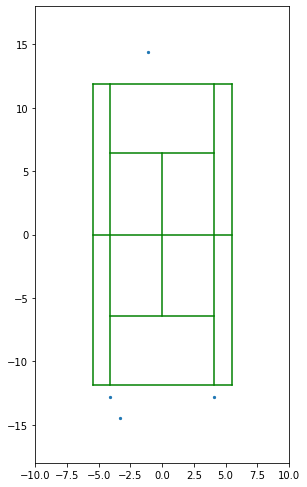

In [135]:
x=[-3.345,-1.085,-4.1165,4.1165]
y=[-14.44,14.39,-12.8,-12.8]
plot_bounce(x,y)

In [179]:
from numpy import linalg as LA
pl=np.array([-4.1165,11.89])
pr=np.array([4.1165,11.89])

ball_x,ball_y,ave=reverseXYList(ball_x_list,ball_y_list,"minus")
player_a_x,player_a_y,ave=reverseXYList(player_wait_x_list,player_wait_y_list,"plus")
ball_x=np.array(ball_x)
ball_y=np.array(ball_y)
player_a_x=np.array(player_a_x)
player_a_y=np.array(player_a_y)

won_degree_list=[]
lost_degree_list=[]
won_distance_list=[]
lost_distance_list=[]
won_y_list=[]
lost_y_list=[]

for j in range(len(ball_x)):#len(ball_x)
    l=np.array([pl[0]-ball_x[j],pl[1]-ball_y[j]])
    r=np.array([pr[0]-ball_x[j],pr[1]-ball_y[j]])
    p=np.array([player_a_x[j]-ball_x[j],player_a_y[j]-ball_y[j]])
    
    i_l = np.inner(p, l)
    n_l = LA.norm(p) * LA.norm(l)
    c_l = i_l / n_l
    a_l = np.rad2deg(np.arccos(np.clip(c_l, -1.0, 1.0)))
    
    i_r = np.inner(p, r)
    n_r = LA.norm(p) * LA.norm(r)
    c_r = i_r / n_r
    a_r = np.rad2deg(np.arccos(np.clip(c_r, -1.0, 1.0)))
    
    a=max(a_l,a_r)
    print(ball_x[0],ball_y[0])
    print(player_a_x[0],player_a_y[0])
    print(a_l,a_r)
    print(l,r)
    print(p)
    print(a_l,a_r,a)
    
    p_temp_l=LA.norm(np.array([pl[0]-player_a_x[j],pl[1]-player_a_y[j]]))
    p_temp_r=LA.norm(np.array([pr[0]-player_a_x[j],pr[1]-player_a_y[j]]))
    print("distance",p_temp_l,p_temp_r)
    
    
    if(a_l>a_r):
        p_temp=np.array([pl[0]-player_a_x[j],pl[1]-player_a_y[j]])
        #distance=LA.norm(l)-LA.norm(p_temp)
        distance=LA.norm(p_temp)
    else:
        p_temp=np.array([pr[0]-player_a_x[j],pr[1]-player_a_y[j]])
        #distance=LA.norm(r)-LA.norm(p_temp)
        distance=LA.norm(p_temp)
    if(winner_list[j]=='Nakashima'):
        won_degree_list.append(a)
        won_distance_list.append(distance)
        won_y_list.append(ball_y[j])
    elif(winner_list[j]=='Nishioka'):
        lost_degree_list.append(a)
        lost_y_list.append(ball_y[j])
        lost_distance_list.append(distance)
    print(distance)
    
won_degree_list=np.array(won_degree_list)
lost_degree_list=np.array(lost_degree_list)
won_distance_list=np.array(won_distance_list)
lost_distance_list=np.array(lost_distance_list) 

won_y_list=np.array(won_y_list)
lost_y_list=np.array(lost_y_list)

won_y_list=won_y_list[won_y_list>-20]
lost_y_list=lost_y_list[lost_y_list>-20]


-3.345 -14.440000000000001
-1.085 14.39
6.160635804290628 11.339597501980334
[-0.7715 26.33  ] [ 7.4615 26.33  ]
[ 2.26 28.83]
6.160635804290628 11.339597501980334 11.339597501980334
distance 3.929375554716042 5.771100609935682
5.771100609935682
-3.345 -14.440000000000001
-1.085 14.39
11.364753843130318 7.792542664155987
[-0.0615 23.72  ] [ 8.1715 23.72  ]
[ 5.13 25.87]
11.364753843130318 7.792542664155987 11.364753843130318
distance 5.619089984152237 3.7246774692582445
5.619089984152237
-3.345 -14.440000000000001
-1.085 14.39
10.156483617398683 7.732970479463764
[-7.3815 25.75  ] [ 0.8515 25.75  ]
[-2.71 26.5 ]
10.156483617398683 7.732970479463764 10.156483617398683
distance 4.731322463117474 3.6396129258480228
4.731322463117474
-3.345 -14.440000000000001
-1.085 14.39
7.483519183773906 9.90464465411547
[-9.3915 25.87  ] [-1.1585 25.87  ]
[-6.03 27.27]
7.483519183773906 9.90464465411547 9.90464465411547
distance 3.641384661087043 5.068679537118124
5.068679537118124
-3.345 -14.440000000

distance 5.0617430051317305 4.785849167075787
5.0617430051317305
-3.345 -14.440000000000001
-1.085 14.39
15.539084915572422 3.126037854067032
[-2.3015 24.92  ] [ 5.9315 24.92  ]
[ 4.74 26.18]
15.539084915572422 3.126037854067032 15.539084915572422
distance 7.153343431571002 1.7341488546258064
7.153343431571002
-3.345 -14.440000000000001
-1.085 14.39
11.305181654185194 6.0960661935534715
[-1.500e-03  2.627e+01] [ 8.2315 26.27  ]
[ 5.49 27.47]
11.305181654185194 6.0960661935534715 11.305181654185194
distance 5.621082836073491 2.992627983896428
5.621082836073491
-3.345 -14.440000000000001
-1.085 14.39
5.885424525212895 14.398043112108393
[-7.8215 22.42  ] [ 0.4115 22.42  ]
[-6.   25.29]
5.885424525212895 14.398043112108393 14.398043112108393
distance 3.399229655377816 7.0245449852641695
7.0245449852641695
-3.345 -14.440000000000001
-1.085 14.39
18.572912059425086 7.775344425230045
[-7.8315 16.81  ] [ 0.4015 16.81  ]
[-2.11 18.79]
18.572912059425086 7.775344425230045 18.572912059425086
dis

[-7.4015 26.17  ] [ 0.8315 26.17  ]
[-1.85 27.4 ]
11.92951983508831 5.682496074691179 11.92951983508831
distance 5.686128054309013 2.9501427507834257
5.686128054309013
-3.345 -14.440000000000001
-1.085 14.39
4.506604440742173 17.613168880023643
[-4.1015 21.06  ] [ 4.1315 21.06  ]
[-2.85 24.96]
4.506604440742173 17.613168880023643 17.613168880023643
distance 4.095882353046777 7.996958312383527
7.996958312383527
-3.345 -14.440000000000001
-1.085 14.39
25.433038196614515 2.900763109763488
[-0.9015 15.69  ] [ 7.3315 15.69  ]
[ 8.18 20.1 ]
25.433038196614515 2.900763109763488 25.433038196614515
distance 10.095629859003349 4.490885463914661
10.095629859003349
-3.345 -14.440000000000001
-1.085 14.39
8.057965051973126 10.247941271519128
[-10.3715  23.96  ] [-2.1385 23.96  ]
[-7.57 27.58]
8.057965051973126 10.247941271519128 10.247941271519128
distance 4.577423101484067 6.527295937063066
6.527295937063066
-3.345 -14.440000000000001
-1.085 14.39
37.556856308942265 19.034425304890117
[-8.0615 24.

[-6.7215 25.52  ] [ 1.5115 25.52  ]
[-2.58 27.22]
9.34104836589209 8.804062211539094 9.34104836589209
distance 4.476831720089554 4.430617592390479
4.476831720089554
-3.345 -14.440000000000001
-1.085 14.39
10.475346817952083 7.910876352912015
[-0.8115 25.01  ] [ 7.4215 25.01  ]
[ 4.04 26.66]
10.475346817952083 7.910876352912015 10.475346817952083
distance 5.124407502336245 3.7625845173231656
5.124407502336245
-3.345 -14.440000000000001
-1.085 14.39
15.25066372100185 2.7226786234072824
[-0.1615 25.43  ] [ 8.0715 25.43  ]
[ 6.8  25.58]
15.25066372100185 2.7226786234072824 15.25066372100185
distance 6.963115843499948 1.2803172458418268
6.963115843499948
-3.345 -14.440000000000001
-1.085 14.39
9.583680505068042 7.188732202391802
[-1.150e-02  2.732e+01] [ 8.2215 27.32  ]
[ 3.7  21.97]
9.583680505068042 7.188732202391802 9.583680505068042
distance 6.511354102642554 7.004745694884292
6.511354102642554
-3.345 -14.440000000000001
-1.085 14.39
10.488724361315679 8.28392414894138
[-2.2115 24.76  ]

In [117]:
player_a_x[0],player_a_y[0]

(-1.085, -1.085)

In [118]:
ball_x[0],ball_y[0]

(3.345, 14.440000000000001)

In [169]:
won_y_list.mean()

-11.521855670103092

In [170]:
lost_y_list.mean()

-12.959349593495936

In [143]:
won_distance_list.mean()

6.968420905792084

In [144]:
lost_distance_list.mean()

7.179947735000543

In [146]:
won_degree_list.mean()

13.242993401773816

In [145]:
lost_degree_list.mean()

12.787890509714671

(array([ 2.,  1.,  3.,  4.,  9.,  8., 11.,  8., 10.,  7.,  9.,  7.,  8.,
        10.,  3.,  2.,  4.,  1.,  3.,  2.,  2.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.]),
 array([-15.25 , -15.021, -14.792, -14.563, -14.334, -14.105, -13.876,
        -13.647, -13.418, -13.189, -12.96 , -12.731, -12.502, -12.273,
        -12.044, -11.815, -11.586, -11.357, -11.128, -10.899, -10.67 ,
        -10.441, -10.212,  -9.983,  -9.754,  -9.525,  -9.296,  -9.067,
         -8.838,  -8.609,  -8.38 ,  -8.151,  -7.922,  -7.693,  -7.464,
         -7.235,  -7.006,  -6.777,  -6.548,  -6.319,  -6.09 ,  -5.861,
         -5.632,  -5.403,  -5.174,  -4.945,  -4.716,  -4.487,  -4.258,
         -4.029,  -3.8  ]),
 <a list of 1 Patch objects>)

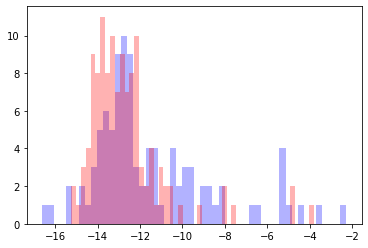

In [181]:
plt.hist(won_y_list, bins=50, alpha=0.3, histtype='stepfilled', color='b')
plt.hist(lost_y_list, bins=50, alpha=0.3, histtype='stepfilled', color='r')
#plt.xlim([-20,0])

(array([ 4., 11., 19., 19., 13.,  8.,  6.,  5.,  6.,  5.,  2.,  3.,  8.,
         1.,  2.,  2.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 8.47263174,  9.0563008 ,  9.63996986, 10.22363892, 10.80730798,
        11.39097704, 11.9746461 , 12.55831516, 13.14198422, 13.72565328,
        14.30932234, 14.8929914 , 15.47666045, 16.06032951, 16.64399857,
        17.22766763, 17.81133669, 18.39500575, 18.97867481, 19.56234387,
        20.14601293, 20.72968199, 21.31335105, 21.89702011, 22.48068917,
        23.06435823, 23.64802728, 24.23169634, 24.8153654 , 25.39903446,
        25.98270352, 26.56637258, 27.15004164, 27.7337107 , 28.31737976,
        28.90104882, 29.48471788, 30.06838694, 30.652056  , 31.23572505,
        31.81939411, 32.40306317, 32.98673223, 33.57040129, 34.15407035,
        34.73773941, 35.32140847, 35.90507753, 36.48874659,

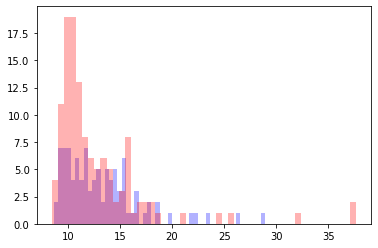

In [182]:
plt.hist(won_degree_list, bins=50, alpha=0.3, histtype='stepfilled', color='b')
plt.hist(lost_degree_list, bins=50, alpha=0.3, histtype='stepfilled', color='r')

(array([27., 24., 21., 14.,  5.,  1.,  2.,  1.,  1.,  1.]),
 array([ 8.68329231, 10.71041143, 12.73753056, 14.76464969, 16.79176881,
        18.81888794, 20.84600706, 22.87312619, 24.90024532, 26.92736444,
        28.95448357]),
 <a list of 10 Patch objects>)

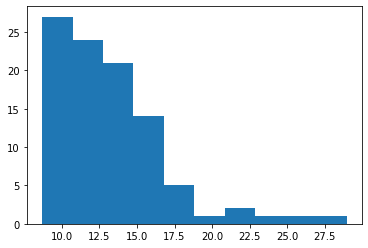

In [158]:
plt.hist(won_degree_list)

(array([66., 30., 16.,  5.,  1.,  2.,  0.,  0.,  1.,  2.]),
 array([ 8.47263174, 11.39097704, 14.30932234, 17.22766763, 20.14601293,
        23.06435823, 25.98270352, 28.90104882, 31.81939411, 34.73773941,
        37.65608471]),
 <a list of 10 Patch objects>)

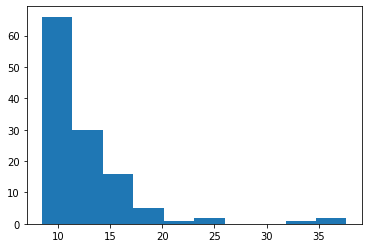

In [161]:
plt.hist(lost_degree_list)

(array([66., 30., 16.,  5.,  1.,  2.,  0.,  0.,  1.,  2.]),
 array([ 8.47263174, 11.39097704, 14.30932234, 17.22766763, 20.14601293,
        23.06435823, 25.98270352, 28.90104882, 31.81939411, 34.73773941,
        37.65608471]),
 <a list of 10 Patch objects>)

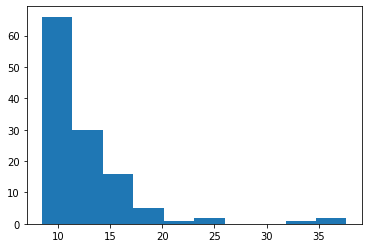

In [160]:
plt.hist(lost_degree_list)

(array([115.,   3.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([ 4.18765116,  8.65528732, 13.12292348, 17.59055964, 22.0581958 ,
        26.52583196, 30.99346812, 35.46110427, 39.92874043, 44.39637659,
        48.86401275]),
 <a list of 10 Patch objects>)

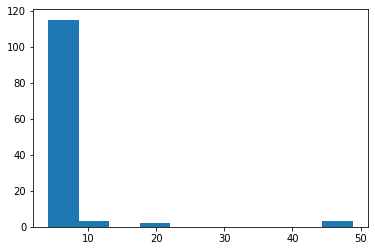

In [157]:
plt.hist(lost_distance_list)

In [32]:
ball_returner_x_list

[-3.345,
 -4.055000000000001,
 3.2649999999999997,
 5.2749999999999995,
 -4.755000000000001,
 2.8649999999999993,
 4.1049999999999995,
 4.735,
 4.624999999999999,
 2.874999999999999,
 4.915,
 -3.3750000000000004,
 -2.6650000000000005,
 2.835,
 4.765,
 0.1349999999999998,
 -0.6050000000000004,
 -0.6350000000000007,
 5.3549999999999995,
 -3.055,
 0.14499999999999957,
 3.0949999999999998,
 -2.1050000000000004,
 2.8649999999999993,
 2.175,
 3.8950000000000005,
 -1.8250000000000002,
 -2.4150000000000005,
 -1.5050000000000003,
 -1.1950000000000003,
 -4.7250000000000005,
 -0.8050000000000006,
 -3.995,
 4.954999999999999,
 4.204999999999999,
 -0.9850000000000003,
 0.1349999999999998,
 -3.1750000000000003,
 4.534999999999999,
 -2.3350000000000004,
 4.675,
 0.1349999999999998,
 1.3549999999999995,
 -0.9850000000000003,
 -0.1750000000000007,
 3.255,
 0.6049999999999995,
 -3.625,
 -3.1550000000000002,
 7.755,
 3.6949999999999994,
 5.134999999999999,
 2.2249999999999996,
 3.374999999999999,
 -0.525

In [ ]:
#ロジスティック回帰
#df_shot_nakashimaのnthの大きい順でtop3を抽出、



In [183]:
df_shot_nakashima

,index,point,frame,ballx,bally,playerAx,playerAy,playerBx,playerBy,hitplayer,...,bally_f,playerAx_f,playerAy_f,playerBx_f,playerBy_f,hitplayer_x,hitplayer_y,waitplayer_x,waitplayer_y,nth
7,7,4,2307.0,2.14,-2.55,3.65,-2.55,4.4,26.28,Nakashima,...,-14.44,-1.835,-14.44,-1.085,14.39,-1.835,-14.44,-1.085,14.39,3
11,11,4,2389.0,1.43,0.06,2.78,0.06,6.56,25.93,Nakashima,...,-11.83,-2.705,-11.83,1.075,14.04,-2.705,-11.83,1.075,14.04,7
15,15,4,2465.0,8.75,-1.97,7.43,-1.97,6.04,24.53,Nakashima,...,-13.86,1.945,-13.86,0.555,12.64,1.945,-13.86,0.555,12.64,11
19,19,4,2566.0,10.76,-2.09,8.91,-2.09,4.73,25.18,Nakashima,...,-13.98,3.425,-13.98,-0.755,13.29,3.425,-13.98,-0.755,13.29,15
23,23,6,3570.0,0.73,-0.93,2.36,-0.93,9.5,22.96,Nakashima,...,-12.82,-3.125,-12.82,4.015,11.07,-3.125,-12.82,4.015,11.07,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974,1974,304,261050.0,3.54,-2.41,4.6,-2.41,5.83,25.74,Nakashima,...,-14.30,-0.885,-14.30,0.345,13.85,-0.885,-14.30,0.345,13.85,5
1978,1978,304,261129.0,0.46,-1.76,1.92,-1.76,6.56,24.8,Nakashima,...,-13.65,-3.565,-13.65,1.075,12.91,-3.565,-13.65,1.075,12.91,9
1982,1982,304,261207.0,6.16,-1.75,5.64,-1.75,5.44,23.99,Nakashima,...,-13.64,0.155,-13.64,-0.045,12.10,0.155,-13.64,-0.045,12.10,13
1986,1986,304,261291.0,3.98,-1.62,4.65,-1.62,5.72,26.08,Nakashima,...,-13.51,-0.835,-13.51,0.235,14.19,-0.835,-13.51,0.235,14.19,17


In [184]:
df_shot_nakashima.to_csv("nakashima.csv")